In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import os
import numpy as np
import pandas as pd
import squidpy as sq

import seaborn as sns
import anndata as ad

In [8]:
base_path= "/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/raw_datasets"

def load_scRNA_GSE149457(data_path):
    """
    This function processes the GSE149457 dataset and returns the concatenated AnnData object.
    """
    # Get the raw data

    sc1 = sc.read_10x_h5(os.path.join(data_path, "GSM4502475_chicken_heart_scRNAseq_D4_filtered_feature_bc_matrix.h5"))
    sc2 = sc.read_10x_h5(os.path.join(data_path, "GSM4502476_chicken_heart_scRNAseq_D7_LV_filtered_feature_bc_matrix.h5"))
    sc3 = sc.read_10x_h5(os.path.join(data_path, "GSM4502477_chicken_heart_scRNAseq_D7_RV_filtered_feature_bc_matrix.h5"))
    sc4 = sc.read_10x_h5(os.path.join(data_path, "GSM4502478_chicken_heart_scRNAseq_D10_LV_filtered_feature_bc_matrix.h5"))
    sc5 = sc.read_10x_h5(os.path.join(data_path, "GSM4502479_chicken_heart_scRNAseq_D10_RV_filtered_feature_bc_matrix.h5"))
    sc6 = sc.read_10x_h5(os.path.join(data_path, "GSM4502480_chicken_heart_scRNAseq_D14_LV_filtered_feature_bc_matrix.h5"))
    sc7 = sc.read_10x_h5(os.path.join(data_path, "GSM4502481_chicken_heart_scRNAseq_D14_RV_filtered_feature_bc_matrix.h5"))
    meta = pd.read_csv(os.path.join(data_path, "scRNAseq_metadata.csv"), index_col=0)
    sc1.var_names_make_unique()
    sc2.var_names_make_unique()
    sc3.var_names_make_unique()
    sc4.var_names_make_unique()
    sc5.var_names_make_unique()
    sc6.var_names_make_unique()
    sc7.var_names_make_unique()
    scRNA = sc1.concatenate(sc2, sc3, sc4, sc5, sc6, sc7)

    ## Process the metadata because of data inconsistency
    meta = meta.reset_index()
    # Rename for clarity
    meta = meta.rename(columns={"index": "original_id"})
    # Split into sample and barcode based on the first underscore
    meta["sample"] = meta["original_id"].str.extract(r"^(.*?)(?=_)")      
    meta["barcode"] = meta["original_id"].str.extract(r"^[^_]+_(.*)$")

    batch_map = {"D4": "0", "D7-LV": "1", "D7-RV": "2", "D10-LV": "3", "D10-RV": "4", "D14-LV": "5", "D14-RV": "6"}
   
    meta["Batch"] = meta["sample"].map(batch_map)
    meta["combined"] = meta["barcode"] + "-1-" + meta["Batch"]

    meta.set_index("combined", inplace=True)
    meta = meta.drop(columns=["Batch"])
    meta = meta.loc[scRNA.obs_names.intersection(meta.index)]
    # Join into AnnData object
    scRNA.obs = scRNA.obs.join(meta)
    scRNA.obs = scRNA.obs.rename(columns={"celltypes.0.5": "celltype"})
    scRNA = scRNA[scRNA.obs["celltype"].notna()]


    return scRNA
    

def load_scRNA_GSE232025(data_path):
    """
    This function processes the GSE232025 dataset and returns the concatenated AnnData object.
    """
    sc1= sc.read_h5ad(os.path.join(data_path, "d0_spatial_scRNAseq.h5ad"))
    sc1.obs["Batch"] = "0"
    sc2= sc.read_h5ad(os.path.join(data_path, "d1_spatial_scRNAseq.h5ad"))
    sc2.obs["Batch"] = "1"
    sc3= sc.read_h5ad(os.path.join(data_path, "d2_spatial_scRNAseq.h5ad"))
    sc3.obs["Batch"] = "2"
    sc4= sc.read_h5ad(os.path.join(data_path, "d3_spatial_scRNAseq.h5ad"))
    sc4.obs["Batch"] = "3"
    sc5= sc.read_h5ad(os.path.join(data_path, "d4_spatial_scRNAseq.h5ad"))
    sc5.obs["Batch"] = "4"

    adatas = [sc1, sc2, sc3, sc4, sc5]

    ## cell color mapping
    all_cell_types = set()
    for adata in adatas:
        all_cell_types.update(adata.obs["Annotation"].unique())

    # Create a consistent color map for all cell types
    palette = sns.color_palette("tab20", len(all_cell_types))
    color_dict = dict(zip(sorted(all_cell_types), palette))

    for sci in adatas:
        sci.obs = sci.obs.rename(columns={"Annotation": "celltype", "Batch": "day"})
        sci.obs["celltype"] = sci.obs["celltype"].astype(str)
        sci.obs["color"] = sci.obs["celltype"].map(color_dict)

    scRNA = ad.concat(adatas, label='day', keys=[a.obs['day'][0] for a in adatas])

    return scRNA



def apply_processing_steps(scRNA):
    """
    This function applies the processing steps to the AnnData object.
    """
    
    # sc.pp.highly_variable_genes(scRNA, batch_key='day', n_top_genes=2000, flavor='seurat_v3')
    # scRNA = scRNA[:, scRNA.var.highly_variable]
    # sc.tl.pca(scRNA)
    # sc.pp.neighbors(scRNA)
    # sc.tl.umap(scRNA)

    sc.pp.normalize_total(scRNA, target_sum=1e4)
    sc.pp.log1p(scRNA)
    sc.pp.highly_variable_genes(scRNA, n_top_genes=2000, subset=True)
    sc.pp.scale(scRNA, max_value=10)
    sc.tl.pca(scRNA)
    sc.pp.neighbors(scRNA)
    sc.tl.umap(scRNA)

    return scRNA

def get_concatenated_dynamic_data(GSE_ID, save_path=None, data_type="scRNA"):
    """
    This function concatenates the dynamic data from the raw datasets and saves it as a csv file.
    """
    # Get the raw data

    if GSE_ID == "GSE149457" and data_type == "scRNA":
        data_path = os.path.join(base_path, "GSE149457")
        scRNA = load_scRNA_GSE149457(data_path)
        scRNA = apply_processing_steps(scRNA)
    
    elif GSE_ID == "GSE232025" and data_type == "scRNA":
        data_path = os.path.join(base_path, "GSE232025")
        scRNA = load_scRNA_GSE232025(data_path)
        scRNA = apply_processing_steps(scRNA)
    
    return scRNA

In [14]:
# scRNA= get_concatenated_dynamic_data("GSE149457") # this works
# scRNA= get_concatenated_dynamic_data("GSE232025")

scRNA= ad.read_h5ad("/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/h5ad_processed_datasets/GSE149457_chicken_hearts.h5ad")

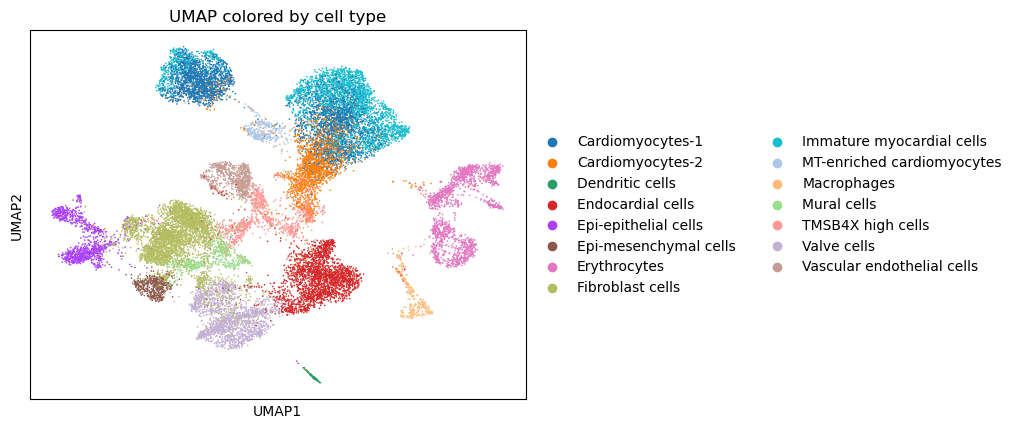

In [15]:
sc.pl.umap(scRNA, color="celltype", title="UMAP colored by cell type")

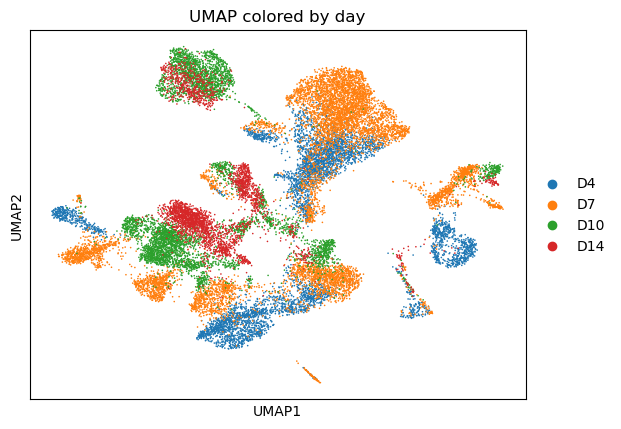

In [16]:
sc.pl.umap(scRNA, color="day", title="UMAP colored by day")

In [6]:
scRNA

AnnData object with n_obs × n_vars = 28757 × 2000
    obs: 'CellID', 'day', 'cell_id', 'celltype', 'color'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'celltype_colors', 'day_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'